In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

NPOINTS = 1024
EPOCHS = 10000
BATCH_SIZE = 64
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4

HIDDEN_DIM = 64
JITTER = 0.1

# Dataset

In [2]:
def toy_data(n: int):
    x1 = np.random.randn(3 * n // 8, 2) + np.array([+2.68860759, -0.5354974])
    s1 = np.zeros(3 * n // 8, dtype=int)
    y1 = np.ones(3 * n // 8, dtype=int)

    x2 = np.random.randn(2 * n // 8, 2) + np.array([-5.56109677, -4.82287713])
    s2 = np.zeros(2 * n // 8, dtype=int)
    y2 = np.zeros(2 * n // 8, dtype=int)

    x3 = np.random.randn(n // 8, 2) + np.array([+5.85321324, +0.30018245])
    s3 = np.ones(n // 8, dtype=int)
    y3 = np.ones(n // 8, dtype=int)

    x4 = np.random.randn(2 * n // 8, 2) + np.array([-5.39470544, +5.55908816])
    s4 = np.ones(2 * n // 8, dtype=int)
    y4 = np.zeros(2 * n // 8, dtype=int)

    x = np.concatenate((x1, x2, x3, x4), dtype=np.float32)
    s = np.concatenate((s1, s2, s3, s4), dtype=np.int64)
    y = np.concatenate((y1, y2, y3, y4), dtype=np.int64)
    return x, s, y


x, s, y = toy_data(n=NPOINTS)
dataset = TensorDataset(*[torch.tensor(el) for el in (x, s, y)])
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

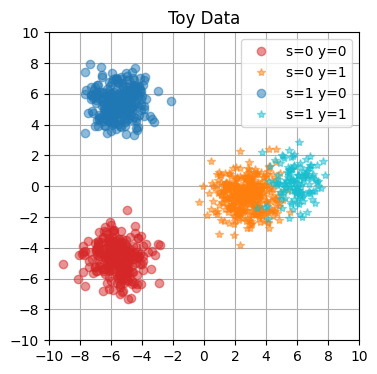

In [3]:
def plot_data(x, s, y):
    plt.plot(*x[(s == 0) * (y == 0)].T, "o", c="tab:red", alpha=0.5, label="s=0 y=0")
    plt.plot(*x[(s == 0) * (y == 1)].T, "*", c="tab:orange", alpha=0.5, label="s=0 y=1")
    plt.plot(*x[(s == 1) * (y == 0)].T, "o", c="tab:blue", alpha=0.5, label="s=1 y=0")
    plt.plot(*x[(s == 1) * (y == 1)].T, "*", c="tab:cyan", alpha=0.5, label="s=1 y=1")
    plt.legend()
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.xticks(np.arange(-10, 11, 2))
    plt.yticks(np.arange(-10, 11, 2))
    plt.grid()


plt.figure(figsize=(4, 4))
plt.title("Toy Data")
plot_data(x, s, y)
plt.show()

# Flow Matching

In [4]:
class Flow(nn.Module):
    def __init__(self, dim: int, hidden_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x, t):
        h = torch.cat((x, t.unsqueeze(-1)), dim=-1)
        return self.mlp(h)

    def push(self, x, s, n_steps: int = 64, T: float = 1.0):
        x, s = torch.as_tensor(x), torch.as_tensor(s)
        t = torch.clone(s).to(dtype=x.dtype)
        with torch.no_grad():
            dt = T / n_steps * torch.where(s == 0, +1.0, -1.0)
            for _ in range(n_steps):
                x = x + self(x, t) * dt.unsqueeze(-1)
                t = t + dt
        return x

## Independent Coupling

Epochs: 100%|██████████| 10000/10000 [01:44<00:00, 96.02it/s, loss=6.24]


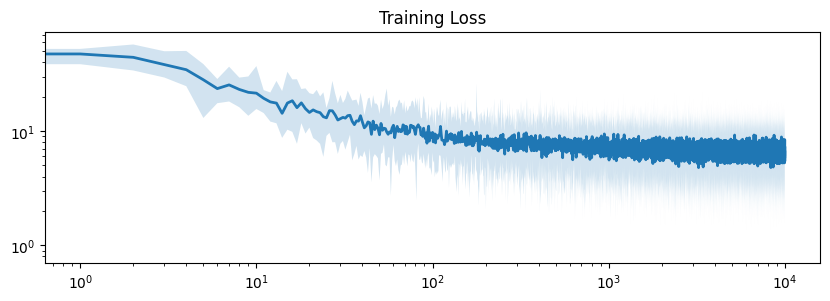

In [5]:
def loss_fn(flow, x, s):
    x0, x1 = x[s == 0], x[s == 1]
    n = min(len(x0), len(x1))
    x0, x1 = x0[:n], x1[:n]

    t = torch.rand(n, device=x.device)
    xt = x0 * (1 - t[..., None]) + x1 * t[..., None]
    xt += JITTER * torch.randn_like(xt)
    dx = x1 - x0

    loss = mse_loss(flow(xt, t), dx)
    return loss


model = Flow(dim=2, hidden_dim=HIDDEN_DIM)
model.train()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

losses = []
for epoch in (pbar := tqdm(range(EPOCHS), desc="Epochs")):
    for x, s, y in dataloader:
        loss = loss_fn(model, x, s)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    pbar.set_postfix({"loss": losses[-1]})
losses = np.array(losses).reshape(EPOCHS, -1)

plt.figure(figsize=(10, 3))
plt.loglog(losses.mean(axis=1), label="Mean Loss", linewidth=2)
plt.fill_between(np.arange(EPOCHS), losses.min(axis=1), losses.max(axis=1), alpha=0.2)
plt.title("Training Loss")
plt.show()

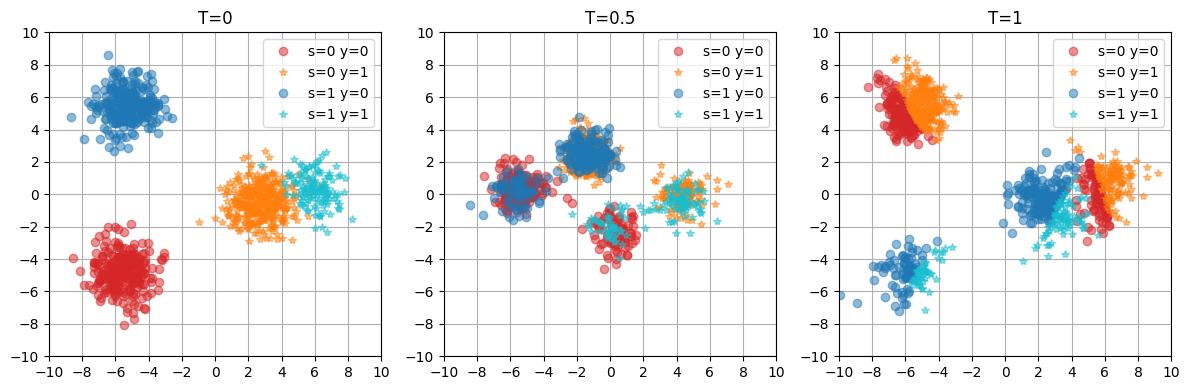

In [6]:
model.eval()
x, s, y = toy_data(n=NPOINTS)
x_mid = model.push(x, s, T=0.5)
x_rev = model.push(x, s, T=1.0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("T=0")
plot_data(x, s, y)
plt.subplot(1, 3, 2)
plt.title("T=0.5")
plot_data(x_mid.cpu().numpy(), s, y)
plt.subplot(1, 3, 3)
plt.title("T=1")
plot_data(x_rev.cpu().numpy(), s, y)
plt.tight_layout()
plt.show()

## Label Coupling

Epochs: 100%|██████████| 10000/10000 [01:56<00:00, 85.63it/s, loss=2.78]


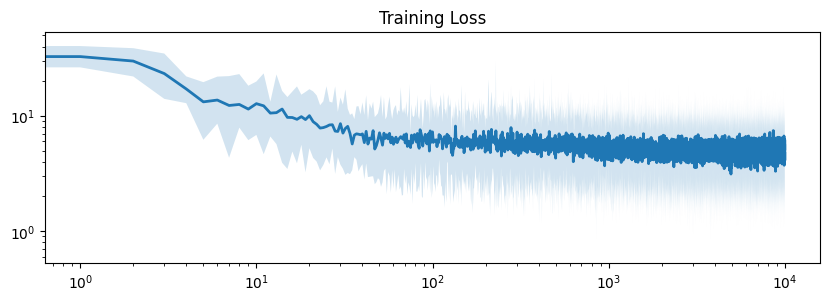

In [7]:
def loss_fn(flow, x, s, y):
    order = torch.argsort(y)
    x, s, y = x[order], s[order], y[order]

    x0, x1 = x[s == 0], x[s == 1]
    n = min(len(x0), len(x1))
    x0 = x0[sorted(np.random.choice(len(x0), (n,), replace=False))]
    x1 = x1[sorted(np.random.choice(len(x1), (n,), replace=False))]

    t = torch.rand(n, device=x.device)
    xt = x0 * (1 - t[..., None]) + x1 * t[..., None]
    xt += JITTER * torch.randn_like(xt)
    dx = x1 - x0

    loss = mse_loss(flow(xt, t), dx)
    return loss


model = Flow(dim=2, hidden_dim=HIDDEN_DIM)
model.train()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

losses = []
for epoch in (pbar := tqdm(range(EPOCHS), desc="Epochs")):
    for x, s, y in dataloader:
        loss = loss_fn(model, x, s, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    pbar.set_postfix({"loss": losses[-1]})
losses = np.array(losses).reshape(EPOCHS, -1)

plt.figure(figsize=(10, 3))
plt.loglog(losses.mean(axis=1), label="Mean Loss", linewidth=2)
plt.fill_between(np.arange(EPOCHS), losses.min(axis=1), losses.max(axis=1), alpha=0.2)
plt.title("Training Loss")
plt.show()

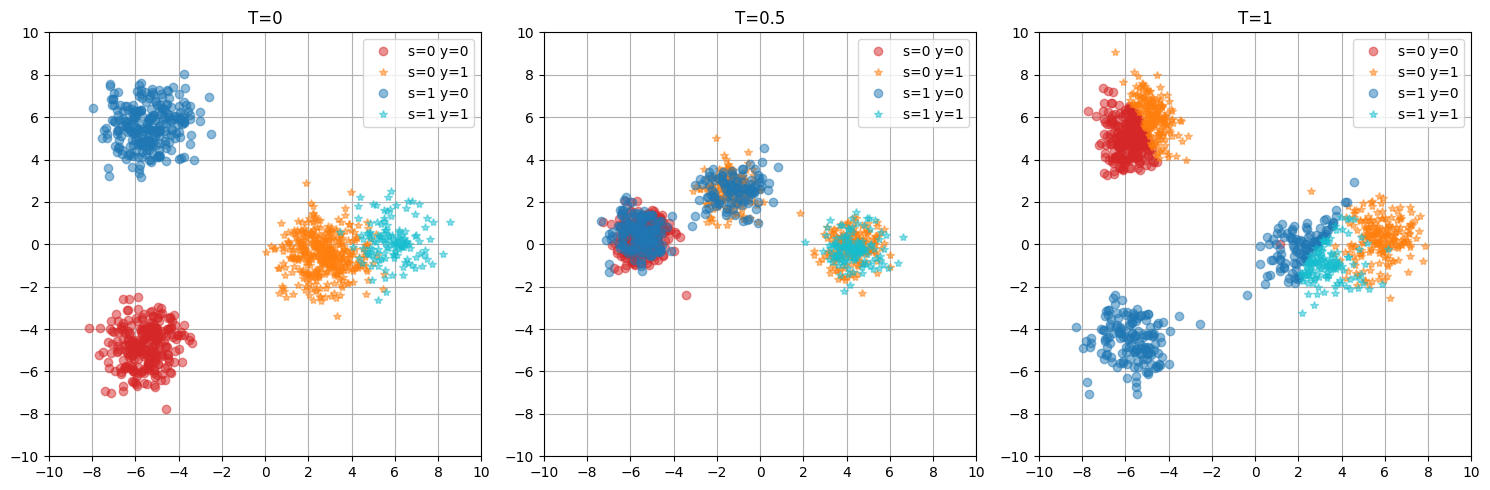

In [8]:
model.eval()
x, s, y = toy_data(n=NPOINTS)
x_mid = model.push(x, s, T=0.5)
x_rev = model.push(x, s, T=1.0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("T=0")
plot_data(x, s, y)
plt.subplot(1, 3, 2)
plt.title("T=0.5")
plot_data(x_mid.cpu().numpy(), s, y)
plt.subplot(1, 3, 3)
plt.title("T=1")
plot_data(x_rev.cpu().numpy(), s, y)
plt.tight_layout()
plt.show()